In [1]:
import numpy as np
import tensorflow as tf
import os
from tensorflow import keras
from PIL import Image
from keras.layers import Layer

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
DIR_MODEL = 'models/xception_fine_no_freeze.h5'
# LayerScale
class LayerScale(Layer):
    """LayerScale as introduced in CaiT: https://arxiv.org/abs/2103.17239.

    Args:
        init_values (float): value to initialize the diagonal matrix of LayerScale.
        projection_dim (int): projection dimension used in LayerScale.
    """

    def __init__(self, init_values: float, projection_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.gamma = tf.Variable(init_values * tf.ones((projection_dim,)))

    def call(self, x, training=False):
        return x * self.gamma
    
model = keras.models.load_model(DIR_MODEL)#, custom_objects={'LayerScale': LayerScale})

In [4]:
# Show all layers idented
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 123,633,202
Trainable params: 123,578,674
Non-trainable params: 54,528
_________________________________________________________________


In [21]:
model.save_weights('tmp.h5', overwrite=True)

# Cargar el modelo Xception sin la capa superior (sin incluir) y con pesos de 'imagenet'
xception_model = tf.keras.applications.Xception(weights=None, include_top=False, input_shape=(224, 224, 3))

# Crear un nuevo modelo con las capas extraídas de Xception
input_layer = xception_model.input
x = xception_model.output

# Agregar las capas Flatten y Dense a tu modelo personalizado
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
output_layer = keras.layers.Dense(10, activation='softmax')(x)

# Crear el modelo final
custom_model = keras.Model(inputs=input_layer, outputs=output_layer)
custom_model.load_weights('tmp.h5', by_name=True)

In [22]:
print(model.layers[0].layers[0].name)
print(model.layers[0].layers[3].name)

print(custom_model.layers[0].name)
print(custom_model.layers[3].name)

input_1
block1_conv1_act
input_4
block1_conv1_act


In [11]:
custom_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [10]:
model.summary(expand_nested=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)      [(None, 224, 224, 3)]     0         |
|                                                               |
| block1_conv1 (Conv2D)     (None, 111, 111, 32)      864       |
|                                                               |
| block1_conv1_bn (BatchNorma  (None, 111, 111, 32)   128       |
| lization)                                                     |
|                                                               |
| block1_conv1_act (Activatio  (None, 111, 111, 32)   0         |
| n)                                                            |
|                                                               |
| block1_conv2 (Conv2D)     (None, 109, 109, 64)      18

In [7]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 0s 467ms/step


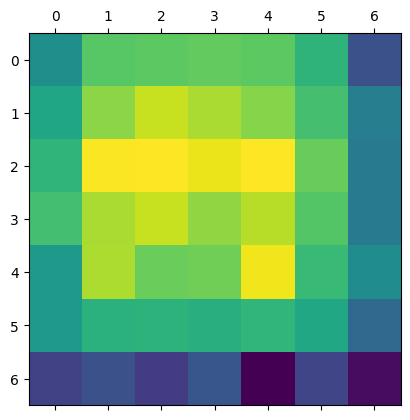

In [23]:
import cv2

image_path = r'Final_dataset_small\Train\Amarillo\Z4MXFNDS7HZ9.jpg'.replace('\\', '/')
img_array = cv2.imread(image_path)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Remove last layer's softmax
custom_model.layers[-1].activation = None

# Print what the top predicted class is
preds = custom_model.predict(img_array)

last_conv_layer_name = "block14_sepconv2_act"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, custom_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()